/home/tordjx/miniconda3/envs/mujoco_py/lib/python3.8/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Acrobot-v1` instead of the unversioned environment `Acrobot`.
  logger.warn(
100%|██████████| 50/50 [00:25<00:00,  1.95it/s, avgreturn=-201]


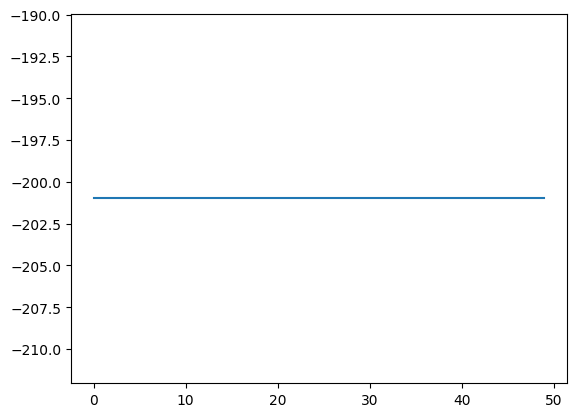

In [1]:
# from train_a2c import *
# from env_hiv import *
# #env = HIVPatient(domain_randomization=False)
# env = gym.make('Acrobot', render_mode="rgb_array")
# config = {'gamma': .99,
#           'learning_rate': 3e-3,
#           'nb_episodes': 10,
#           'entropy_coefficient': 1e-1
#          }

# pi = policyNetwork(env)
# value  = valueNetwork(env)
# agent = a2c_agent(config, pi, value, maxiter = 200)
# res = agent.train(env, 50)
# import matplotlib.pyplot as plt
# plt.plot(res)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hsize = 4
class policyNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        state_dim = env.observation_space.shape[0]
        n_action = env.action_space.n
        self.fc1 = nn.Linear(state_dim, hsize)
        self.fc2 = nn.Linear(hsize, n_action)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(dim=0)
        x = F.relu(self.fc1(x.to(torch.float32)))
        action_scores = self.fc2(x)
        return F.softmax(action_scores,dim=1)

    def sample_action(self, x):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.sample().item()

    def log_prob(self, x, a):
        probabilities = self.forward(x)
        action_distribution = Categorical(probabilities)
        return action_distribution.log_prob(a)
class reinforce_agent:
    def __init__(self, config, policy_network):
        self.device = "cuda" if next(policy_network.parameters()).is_cuda else "cpu"
        self.scalar_dtype = next(policy_network.parameters()).dtype
        self.policy = policy_network
        self.gamma = config['gamma'] if 'gamma' in config.keys() else 0.99
        lr = config['learning_rate'] if 'learning_rate' in config.keys() else 0.001
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()),lr=lr)
        self.nb_episodes = config['nb_episodes'] if 'nb_episodes' in config.keys() else 1

    def sample_action_and_log_prob(self, x):
        probabilities = self.policy(torch.as_tensor(x))
        action_distribution = Categorical(probabilities)
        action = action_distribution.sample()
        log_prob = action_distribution.log_prob(action)
        return action.item(), log_prob
    
    def one_gradient_step(self, env):
        # run trajectories until done
        episodes_sum_of_rewards = []
        log_probs = []
        returns = []
        for ep in range(self.nb_episodes):
            x,_ = env.reset()
            rewards = []
            episode_cum_reward = 0
            it = 0
            while(True):
                it+=1
                a, log_prob = self.sample_action_and_log_prob(x)
                y,r,d,_,_ = env.step(a)
                log_probs.append(log_prob)
                rewards.append(r)
                episode_cum_reward += r
                x=y
                if d or it>200:
                    # compute returns-to-go
                    new_returns = []
                    G_t = 0
                    for r in reversed(rewards):
                        G_t = r + self.gamma * G_t
                        new_returns.append(G_t)
                    new_returns = list(reversed(new_returns))
                    returns.extend(new_returns)
                    episodes_sum_of_rewards.append(episode_cum_reward)
                    break
        # make loss
        returns = torch.tensor(returns)
        log_probs = torch.cat(log_probs)
        loss = -(returns * log_probs).sum()
        # gradient step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.mean(episodes_sum_of_rewards)

    def train(self, env, nb_rollouts):
        avg_sum_rewards = []
        with trange(nb_rollouts) as pbar : 
            for ep in pbar:
                avg = self.one_gradient_step(env)
                pbar.set_postfix(avgreturn = avg)
                avg_sum_rewards.append(avg)
        return avg_sum_rewards
    
class ProjectAgent() :
    def __init__(self, config, env) : 
        self.config = config
        self.env = env
        self.pi = policyNetwork(self.env)
        self.agent =reinforce_agent(config,self.pi)
    def train(self,epochs):
        return self.agent.train(env,epochs)
import gymnasium as gym
import matplotlib.pyplot as plt

#env = gym.make("LunarLander-v2", render_mode="rgb_array")
#env = gym.make('Acrobot', render_mode="rgb_array")
import env_hiv
env = env_hiv.HIVPatient(domain_randomization=False)
config = {'gamma': .99,
          'learning_rate': 0.01,
          'nb_episodes': 10
         }

agent = ProjectAgent(config,env)
returns=agent.train(100)
import matplotlib.pyplot as plt
plt.plot(returns)

  3%|▎         | 3/100 [01:41<54:52, 33.94s/it, avgreturn=3.22e+6]


KeyboardInterrupt: 

In [9]:
env.action_space.n


4